In [92]:
import os
import json
from pathlib import Path
from collections import defaultdict
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap
import glob 
from openai import OpenAI
import time
from pydantic import BaseModel
from dotenv import load_dotenv

In [64]:
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.getenv("OPENAI_API_KEY")
)

In [10]:
data_dir = Path('data')
# Create a nested defaultdict structure with three levels
traces_by_task = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [11]:
# List of valid error types we want to keep
valid_errors = {
    'enverror', 'keyerror', '\nruntimeerror', 
    'assertionerror', '\nvalueerror', 'syntaxerror', '\nimporterror',
    '\nattributeerror', 'outofmemoryerror', 'typeerror'
}

In [12]:
def is_actual_error(observation):
    # Ignore any error words that appear within backticks or double quotes
    # First remove text between backticks
    cleaned_text = re.sub(r'`[^`]*`', '', observation)
    # Then remove text between double quotes
    cleaned_text = re.sub(r'"[^"]*"', '', cleaned_text)
    
    # Check if the cleaned text contains any of our valid error types
    cleaned_text = cleaned_text.lower()
    return any(error in cleaned_text for error in valid_errors)

In [53]:
def get_last_agent_file(folder_path):
    # Find all agent files in the folder
    agent_files = glob.glob(os.path.join(folder_path, "agent_*_*.json"))
    
    if not agent_files:
        return None
    
    # Extract agent numbers and find the highest one
    max_agent_num = 0
    max_agent_file = None
    
    for file in agent_files:
        # Extract the number from filename using regex
        match = re.search(r"agent_(\d+)_\d+\.json", file)
        if match:
            agent_num = int(match.group(1))
            if agent_num > max_agent_num:
                max_agent_num = agent_num
                max_agent_file = file
    
    return max_agent_file

def extract_history_steps(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract history_steps without observation field
        history_steps = data.get('history_steps', [])
        
        # Remove observation field from each step
        # for step in history_steps:
        #     if 'observation' in step:
        #         del step['observation']

        #     if 'action' in step and isinstance(step['action'], dict):
        #         if 'Research Plan and Status' in step['action']:
        #             del step['action']['Research Plan and Status']
        #         if 'Fact Check' in step['action']:
        #             del step['action']['Fact Check']
                
        return history_steps
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_task_name_and_id(folder_path):
    # Split the path into components
    parts = folder_path.split(os.sep)
    
    # Look for task name and run ID in the path
    task_name = None
    run_id = None
    
    for i, part in enumerate(parts):
        if i < len(parts) - 2 and parts[i+2].startswith('0'):  # Assuming run IDs start with numbers
            task_name = part
            run_id = parts[i+2]
            break
    
    return task_name, run_id

def process_all_folders(base_path):
    # Walk through directory structure
    for root, dirs, files in os.walk(base_path):
        # Check if this folder contains agent files
        
        agent_files = [f for f in files if f.startswith("agent_") and f.endswith(".json")]
        if agent_files:
            parts = root.split(os.sep)
            #print(f"{parts}")
            task_name = parts[1]
            model_name = parts[2]
            iteration = parts[3]
            error_observations = []
            last_agent = get_last_agent_file(root)
            if last_agent:
                history = extract_history_steps(last_agent)
                if history:
                    total_steps = len(history)
                    for step_num, step in enumerate(history, 1):
                        observation = step['observation']
                        if is_actual_error(observation):
                            next_steps = []
                            for i in range(1, 6):
                                next_step_idx = step_num + i - 1  # -1 because step_num is 1-indexed but list is 0-indexed
                                if next_step_idx < total_steps:
                                    next_step = history[next_step_idx]
                                    next_step_info = {
                                        'step': step_num + i,
                                        'action': next_step['action']['Action'],
                                        'reflection': next_step['action']['Reflection'],
                                        'thought': next_step['action']['Thought'],
                                        'observation': next_step['observation']
                                    }
                                    next_steps.append(next_step_info)
                            error_info = {
                            'step': step_num,
                            'observation': observation,
                            'next_steps': next_steps
                            }
                            error_observations.append(error_info)
                    if error_observations:
                        traces_by_task[task_name][model_name][iteration] = {
                            'error_observations': error_observations,
                            'total_steps': total_steps,
                        }

In [54]:
base_directory = "data"
process_all_folders(base_directory)

In [55]:
# Convert defaultdict to regular dict for JSON serialization
traces_dict = json.loads(json.dumps(traces_by_task))

# Save to JSON file with nice formatting
with open('error_completion_with_next_steps.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

# Print summary
print("\nSummary of error analysis:")
total_errors = 0
total_next_steps = 0
for task_name, models in traces_dict.items():
    print(f"\nTask: {task_name}")
    task_errors = 0
    task_next_steps = 0
    
    for model_name, iterations in models.items():
        model_errors = sum(len(data['error_observations']) for data in iterations.values())
        
        # Count next steps
        model_next_steps = 0
        for iteration_data in iterations.values():
            for error_obs in iteration_data['error_observations']:
                model_next_steps += len(error_obs.get('next_steps', []))
        
        task_errors += model_errors
        task_next_steps += model_next_steps
        
        print(f"  Model: {model_name}")
        print(f"  Errors: {model_errors}")
        print(f"  Next steps captured: {model_next_steps}")
        print(f"  Avg next steps per error: {model_next_steps/model_errors:.2f}" if model_errors > 0 else "  Avg next steps per error: N/A")
    
    total_errors += task_errors
    total_next_steps += task_next_steps
    
    print(f"  Total task errors: {task_errors}")
    print(f"  Total next steps captured: {task_next_steps}")
    print(f"  Avg next steps per error: {task_next_steps/task_errors:.2f}" if task_errors > 0 else "  Avg next steps per error: N/A")

print(f"\nTotal errors across all tasks: {total_errors}")
print(f"Total next steps captured: {total_next_steps}")
print(f"Average next steps per error: {total_next_steps/total_errors:.2f}" if total_errors > 0 else "Average next steps per error: N/A")


Summary of error analysis:

Task: machine_unlearning
  Model: claude-3-5-sonnet-v2
  Errors: 51
  Next steps captured: 240
  Avg next steps per error: 4.71
  Total task errors: 51
  Total next steps captured: 240
  Avg next steps per error: 4.71

Task: meta-learning
  Model: claude-3-5-sonnet-v2
  Errors: 30
  Next steps captured: 136
  Avg next steps per error: 4.53
  Total task errors: 30
  Total next steps captured: 136
  Avg next steps per error: 4.53

Task: llm-merging
  Model: claude-3-5-sonnet-v2
  Errors: 15
  Next steps captured: 56
  Avg next steps per error: 3.73
  Total task errors: 15
  Total next steps captured: 56
  Avg next steps per error: 3.73

Task: backdoor-trigger-recovery
  Model: claude-3-5-sonnet-v2
  Errors: 27
  Next steps captured: 120
  Avg next steps per error: 4.44
  Total task errors: 27
  Total next steps captured: 120
  Avg next steps per error: 4.44

Task: perception_temporal_action_loc
  Model: claude-3-5-sonnet-v2
  Errors: 30
  Next steps captured:

In [82]:
traces_dict['machine_unlearning']['claude-3-5-sonnet-v2']['0203205627_2107738']['error_observations'][0]

{'step': 24,
 'observation': "EnvError: Your submission didn't achieve a score of 0.0303 according to the leaderboard records. Please double check and resubmit a valid final answer.",
 'next_steps': [{'step': 25,
   'action': ' Edit Script (AI)\n',
   'reflection': ' I made a mistake in trying to submit development phase results as final. The error reminds us that we need to:\n1. Be more thorough in our testing\n2. Consider that dev phase (CIFAR-10) and test phase (CASIA-SURF) may behave differently\n3. Need to further improve the forgetting mechanism as forget accuracy is still too high\n\n',
   'thought': " Let's try to strengthen the forgetting mechanism while maintaining stability by:\n1. Increasing the layer_scale parameter to 0.7 for stronger gradient effects\n2. Adding targeted dropout during forget phase\n3. Making noise level adaptive based on layer depth\n\n",
   'observation': 'The edited file is saved to methods/MyMethod.py. Here is the diff, please check if the edit is cor

In [87]:
def process_and_analyze_files(error_completion_data):
    
    class Step(BaseModel):
        Status: int

    for task_name, task_data in error_completion_data.items():
        for model_name, model_data in task_data.items():
            for iteration, iteration_data in model_data.items():
                # Process error observations
                for error_idx, error_obs in enumerate(iteration_data.get("error_observations", [])):
                    error_step = {
                        "step_number": error_obs.get("step"),
                        "content": error_obs.get("observation", ""),
                        "Next Steps": error_obs.get("next_steps", [])
                    }
                    prompt = f"""
                        Below is a detailed chain-of-thought from an agent after encountering an error message:
                        {error_step}

                        Based on the provided debugging steps, classify the agent response regarding the error as follows:

                        1 -> Fixed the error: The agent identified the issue and implemented a solution that resolved the error.
                        2 -> Tried to fix the error but didn't: The agent attempted to address the error but the fix was not successful.
                        3 -> Didn't even try to fix the error and just went off doing something else: The agent did not directly attempt to resolve the error but instead focused on other tasks unrelated to fixing it.
                        
                        Output only the corresponding number (1, 2, or 3).
                    """
                    completion = client.beta.chat.completions.parse(
                            model="gpt-4o-mini",
                            messages=[
                                {
                                    "role": "user",
                                    "content": prompt
                                }
                            ],
                            response_format=Step
                        )
                    
                    response_content = completion.choices[0].message.content
                        
                    response_json = json.loads(response_content)
                    #print(response_json['Status'])
                    traces_dict[task_name][model_name][iteration]['error_observations'][error_idx]['Status'] = response_json['Status']


In [ ]:
with open("error_completion_with_next_steps.json", "r") as f:
     data = json.load(f)

process_and_analyze_files(data)

with open('error_completion_with_next_steps.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

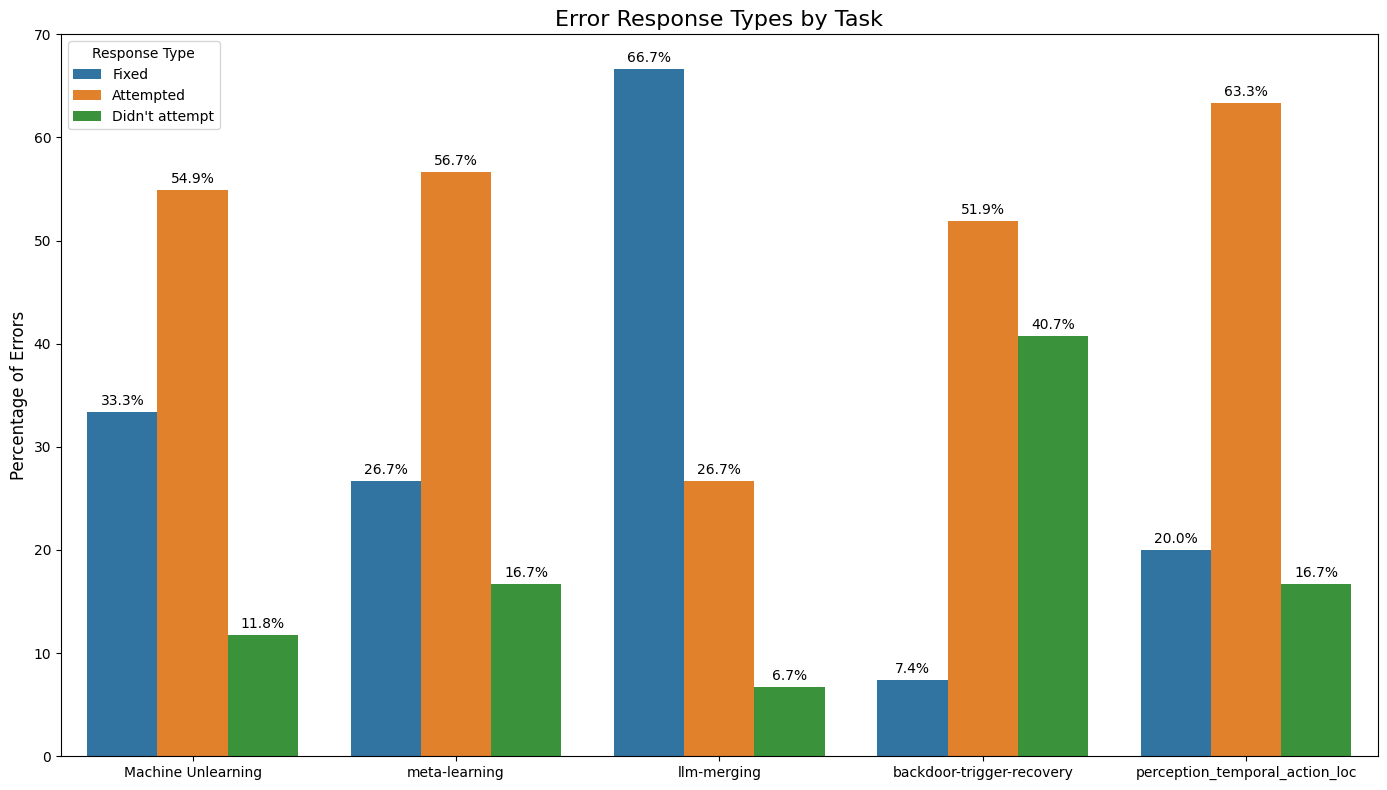


Summary Statistics:
Total tasks analyzed: 5
Average percentage of errors fixed: 30.8%
Average percentage of errors attempted but not fixed: 50.7%
Total errors across all tasks: 153.0


In [99]:
with open('error_completion_with_next_steps.json', 'r') as f:
    error_data = json.load(f)

# Initialize data structure to store counts for each task
task_error_stats = {}

# Define custom task names mapping
task_name_mapping = {
    "machine_unlearning": "Machine Unlearning",
    "code_debugging": "Code Debugging",
    "math_problem_solving": "Math Problem Solving",
    "code_generation": "Code Generation",
    "data_analysis": "Data Analysis",
    "creative_writing": "Creative Writing",
    # Add more mappings as needed for your tasks
}

# Process the data
for task_name, models in error_data.items():
    # Initialize counters for this task
    fixed = 0
    attempted = 0
    didnt_attempt = 0
    total = 0
    
    # Aggregate across all models and iterations
    for model_name, iterations in models.items():
        for iteration, iteration_data in iterations.items():
            for error_obs in iteration_data.get('error_observations', []):
                status = error_obs.get('Status')
                if status == 1:
                    fixed += 1
                elif status == 2:
                    attempted += 1
                elif status == 3:
                    didnt_attempt += 1
                total += 1
    
    # Store the counts for this task
    if total > 0:
        # Use custom name if available, otherwise use original
        display_name = task_name_mapping.get(task_name, task_name)
        task_error_stats[display_name] = {
            'Fixed': (fixed / total) * 100,
            'Attempted': (attempted / total) * 100,
            'Didn\'t attempt': (didnt_attempt / total) * 100,
            'total_errors': total
        }

# Convert to DataFrame for easier plotting
df = pd.DataFrame(task_error_stats).T
df = df.reset_index()
df = df.rename(columns={'index': 'Task'})

# Melt the DataFrame for easier plotting with seaborn
plot_df = pd.melt(
    df, 
    id_vars=['Task', 'total_errors'], 
    value_vars=['Fixed', 'Attempted', 'Didn\'t attempt'],
    var_name='Response Type', 
    value_name='Percentage'
)

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Task', y='Percentage', hue='Response Type', data=plot_df)

# Set task labels with no rotation and center alignment
ax.set_xticklabels(df['Task'], rotation=0, ha='center')

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

# Set plot title and labels
plt.title('Error Response Types by Task', fontsize=16)
plt.ylabel('Percentage of Errors', fontsize=12)
plt.xlabel('', fontsize=12)  # Empty because we have task names
plt.legend(title='Response Type')
plt.tight_layout()

os.makedirs("Error_completion", exist_ok=True)
plt.savefig('Error_completion/error_response_by_task.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total tasks analyzed: {len(task_error_stats)}")
print(f"Average percentage of errors fixed: {df['Fixed'].mean():.1f}%")
print(f"Average percentage of errors attempted but not fixed: {df['Attempted'].mean():.1f}%")
#print(f"Average percentage of errors not attempted: {df['Didn\\'t attempt'].mean():.1f}%")
print(f"Total errors across all tasks: {df['total_errors'].sum()}")